In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
'''
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/5_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/cat_dog')
    '''

In [3]:
files_last=os.listdir('/content/drive/MyDrive/cat_dog/train')
num_files=len(files_last)

In [4]:
print(num_files)

25000


In [10]:
'''
import os
import shutil
import pathlib

original_dir = pathlib.Path("/content/drive/MyDrive/cat_dog/train")
new_base_dir = pathlib.Path("/content/drive/MyDrive/image_seggregated")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir_path = new_base_dir / subset_name / category
        os.makedirs(dir_path, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_dir / fname
            dst = dir_path / fname
            if src.exists():
                shutil.copyfile(src, dst)


make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)
'''

In [6]:
import cv2
import numpy as np
import os


labels = ['cat', 'dog']


img_size = 224

def get_data(data_dir):
    images = []
    image_labels = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:

                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]

                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                images.append(resized_arr)
                image_labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    return np.array(images), np.array(image_labels)

In [7]:
train_images,train_labels=get_data('/content/drive/MyDrive/image_seggregated/train')
val_images,val_labels=get_data('/content/drive/MyDrive/image_seggregated/validation')

In [8]:
train_images[0].shape

(224, 224, 3)

In [9]:
train_images.shape

(2000, 224, 224, 3)

In [10]:
train_labels.shape

(2000,)

In [11]:
np.unique(train_labels)

array([0, 1])

In [12]:
type(val_labels)

numpy.ndarray

In [13]:
x_train=np.array(train_images).astype('float32')/255
x_val=np.array(val_images).astype('float32')/255


In [14]:
y_train=np.array(train_labels)
y_val=np.array(val_labels)

In [15]:
len(x_train)

2000

In [16]:
x_train.shape

(2000, 224, 224, 3)

In [17]:

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(x_train)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

train_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Dropout

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_base.layers:
    layer.trainable = False

vgg_model = Sequential()
vgg_model.add(vgg_base)
vgg_model.add(Flatten())

vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dropout(0.2))
vgg_model.add(Dense(64, activation='relu'))
vgg_model.add(Dense(1, activation='sigmoid'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
vgg_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
vgg_model.fit(train_generator, validation_data=val_generator,epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6705 - loss: 0.6492

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 777ms/step - accuracy: 0.6720 - loss: 0.6467 - val_accuracy: 0.8720 - val_loss: 0.2975
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 525ms/step - accuracy: 0.8614 - loss: 0.3267 - val_accuracy: 0.8900 - val_loss: 0.2611
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 517ms/step - accuracy: 0.8989 - loss: 0.2425 - val_accuracy: 0.9070 - val_loss: 0.2225
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 464ms/step - accuracy: 0.9033 - loss: 0.2080 - val_accuracy: 0.9230 - val_loss: 0.1881
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - accuracy: 0.9271 - loss: 0.1770 - val_accuracy: 0.9220 - val_loss: 0.1854
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 500ms/step - accuracy: 0.9264 - loss: 0.2013 - val_accuracy: 0.9130 - val_loss: 0.2055
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 481ms/step - accuracy: 0.9146 - loss: 0.1974 - val_accuracy: 0.9200 - val_loss: 0.2027
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 506ms/step - accuracy: 0.9306 - loss: 0.1629 - val_accuracy: 0.920

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout
from tensorflow.keras.optimizers import Adam
resnet_base=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in resnet_base.layers:
    layer.trainable=False
resnet_model=Sequential()
resnet_model.add(resnet_base)
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dense(256,activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(128,activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(1,activation='sigmoid'))
resnet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [27]:
resnet_model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])
history=resnet_model.fit(train_generator,validation_data=val_generator,epochs=10)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 568ms/step - accuracy: 0.5027 - loss: 0.7291 - val_accuracy: 0.6190 - val_loss: 0.6745
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 438ms/step - accuracy: 0.5585 - loss: 0.6858 - val_accuracy: 0.5810 - val_loss: 0.6593
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.5558 - loss: 0.6751 - val_accuracy: 0.6150 - val_loss: 0.6558
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 540ms/step - accuracy: 0.5647 - loss: 0.6816 - val_accuracy: 0.6240 - val_loss: 0.6532
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 481ms/step - accuracy: 0.5996 - loss: 0.6683 - val_accuracy: 0.6340 - val_loss: 0.6530
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - accuracy: 0.6104 - loss: 0.6622 - val_accuracy: 0.6140 - val_loss: 0.6552
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 436ms/step - accuracy: 0.5712 - loss: 0.6730 - val_accuracy: 0.6200 - val_loss: 0.6429
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 426ms/step - accuracy: 0.5980 - loss: 0.6717 - val_accu

In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout
from tensorflow.keras.optimizers import Adam
mobilenet_base=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in mobilenet_base.layers:
    layer.trainable=False
mobilenet_model=Sequential()
mobilenet_model.add(mobilenet_base)
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(Dense(256,activation='relu'))
mobilenet_model.add(Dropout(0.2))
mobilenet_model.add(Dense(128,activation='relu'))
mobilenet_model.add(Dropout(0.2))
mobilenet_model.add(Dense(1,activation='sigmoid'))
mobilenet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,618,945 (9.99 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
mobilenet_model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])
history=mobilenet_model.fit(train_generator,validation_data=val_generator,epochs=10)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 541ms/step - accuracy: 0.8609 - loss: 0.3036 - val_accuracy: 0.9700 - val_loss: 0.0865
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 385ms/step - accuracy: 0.9683 - loss: 0.0840 - val_accuracy: 0.9820 - val_loss: 0.0532
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 390ms/step - accuracy: 0.9730 - loss: 0.0645 - val_accuracy: 0.9790 - val_loss: 0.0530
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 391ms/step - accuracy: 0.9698 - loss: 0.0803 - val_accuracy: 0.9830 - val_loss: 0.0417
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 391ms/step - accuracy: 0.9854 - loss: 0.0435 - val_accuracy: 0.9780 - val_loss: 0.0588
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 386ms/step - accuracy: 0.9839 - loss: 0.0471 - val_accuracy: 0.9790 - val_loss: 0.0573
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.9771 - loss: 0.0570 - val_accuracy: 0.9810 - val_loss: 0.0413
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - accuracy: 0.9906 - loss: 0.0372 - val_accu

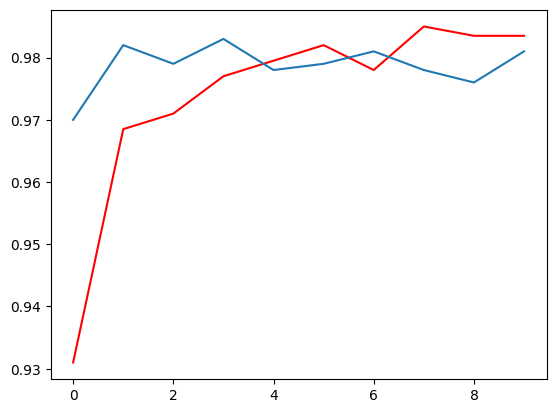

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red')
plt.plot(history.history['val_accuracy'])

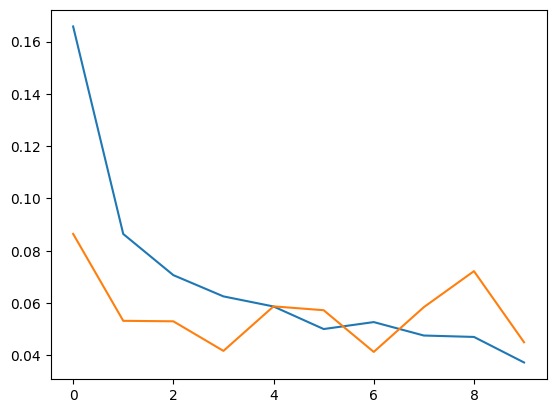

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])